In [65]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [66]:
np.random.rand(4, 10000, 1).shape

(4, 10000, 1)

In [67]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    return series[..., np.newaxis].astype(np.float32)

In [68]:
series = generate_time_series(10000, 50 + 1)
series.shape

(10000, 51, 1)

In [69]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [70]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

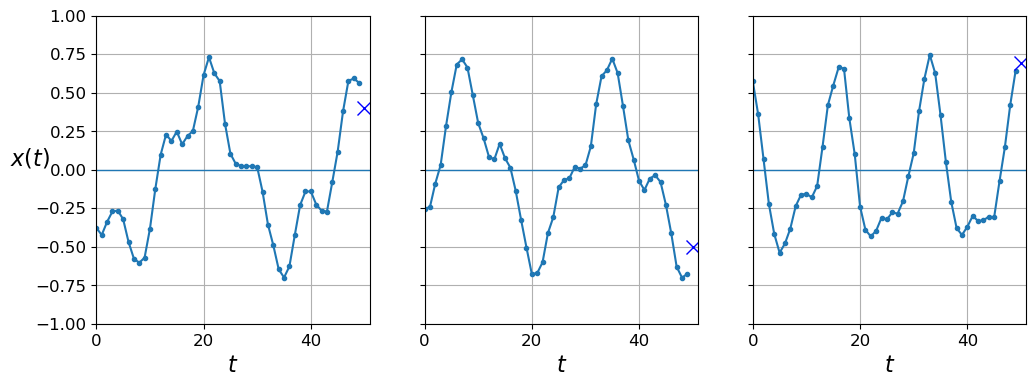

In [71]:
def plot_series(series, y=None, y_pred=None, x_label='$t$', y_label='$x(t)$'):
    plt.plot(series, '.-')
    if y is not None:
        plt.plot(n_steps, y, 'bx', markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, 'ro')
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col == 0 else None))

plt.show()

In [72]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

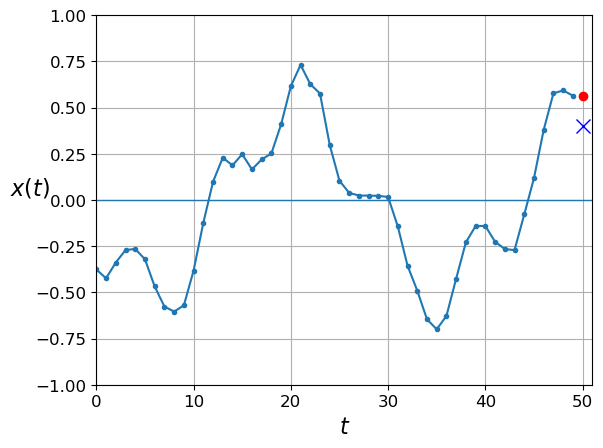

In [73]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [74]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 0s 648us/step - loss: 0.0613 - val_loss: 0.0258
Epoch 2/20
219/219 [==============================] - 0s 471us/step - loss: 0.0164 - val_loss: 0.0122
Epoch 3/20
219/219 [==============================] - 0s 442us/step - loss: 0.0101 - val_loss: 0.0089
Epoch 4/20
219/219 [==============================] - 0s 423us/step - loss: 0.0081 - val_loss: 0.0075
Epoch 5/20
219/219 [==============================] - 0s 425us/step - loss: 0.0069 - val_loss: 0.0064
Epoch 6/20
219/219 [==============================] - 0s 502us/step - loss: 0.0060 - val_loss: 0.0056
Epoch 7/20
219/219 [==============================] - 0s 501us/step - loss: 0.0054 - val_loss: 0.0050
Epoch 8/20
219/219 [==============================] - 0s 507us/step - loss: 0.0049 - val_loss: 0.0046
Epoch 9/20
219/219 [==============================] - 0s 443us/step - loss: 0.0046 - val_loss: 0.0043
Epoch 10/20
219/219 [==============================] - 0s 437us/step - loss: 0.004

In [75]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 361us/step - loss: 0.0034


0.003413532627746463

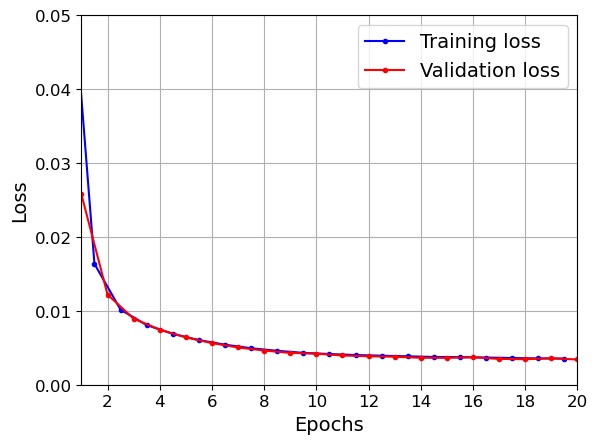

In [76]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, 'b.-', label='Training loss')
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, 'r.-', label='Validation loss')
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)

plot_learning_curves(history.history['loss'], history.history['val_loss'])

In [77]:
np.random.seed(42)
tf.random.set_seed(42)

In [78]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.legacy.Adam(learning_rate=0.005)
model.compile(loss='mse', optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20


219/219 [==============================] - 1s 3ms/step - loss: 0.1782 - val_loss: 0.1503
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.1475 - val_loss: 0.1509
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.1073 - val_loss: 0.0646
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0468 - val_loss: 0.0379
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0318 - val_loss: 0.0281
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0250 - val_loss: 0.0228
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0210 - val_loss: 0.0194
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0183 - val_loss: 0.0170
Epoch 9/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0163 - val_loss: 0.0153
Epoch 10/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0149 - val_loss: 0.0140
Epoch 11/2

In [79]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 761us/step - loss: 0.0109


0.010874506086111069

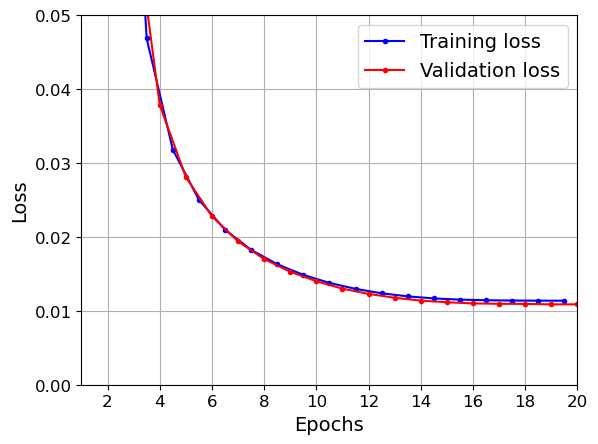

In [80]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

63/63 [==============================] - 0s 862us/step


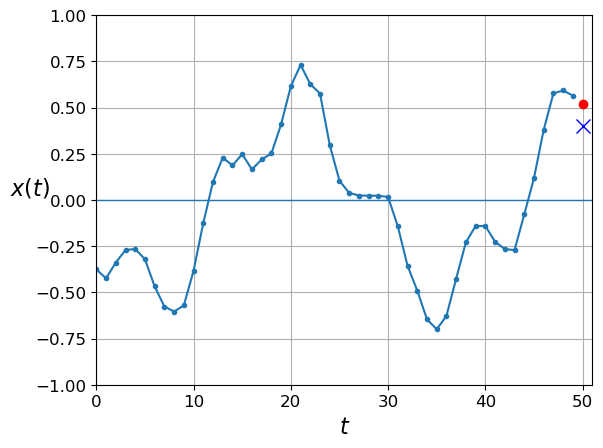

In [81]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [82]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 9ms/step - loss: 0.0325 - val_loss: 0.0079
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0064 - val_loss: 0.0054
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0053 - val_loss: 0.0047
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 7/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0040 - val_loss: 0.0042
Epoch 8/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 9/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 10/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0035 - val_loss: 0.0034

In [83]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0030


0.002975594950839877

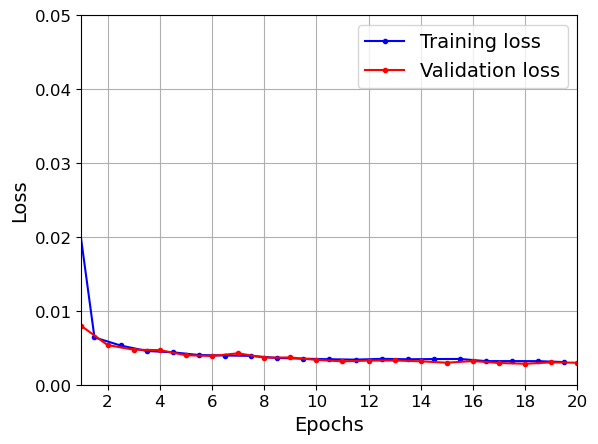

In [84]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

63/63 [==============================] - 0s 2ms/step


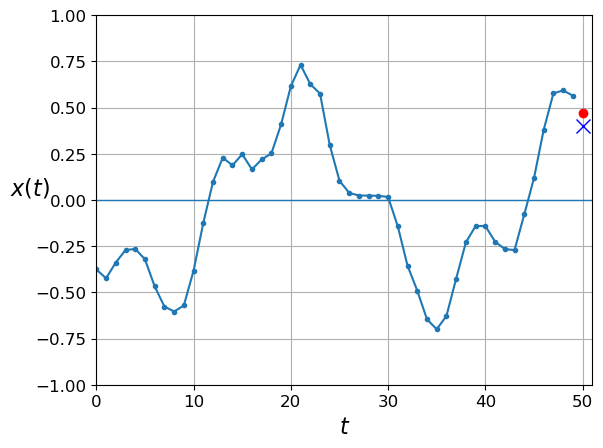

In [85]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])

In [86]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 6ms/step - loss: 0.0172 - val_loss: 0.0050
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 7/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 8/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 9/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 10/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0029

In [87]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 1ms/step - loss: 0.0028


0.002770187333226204

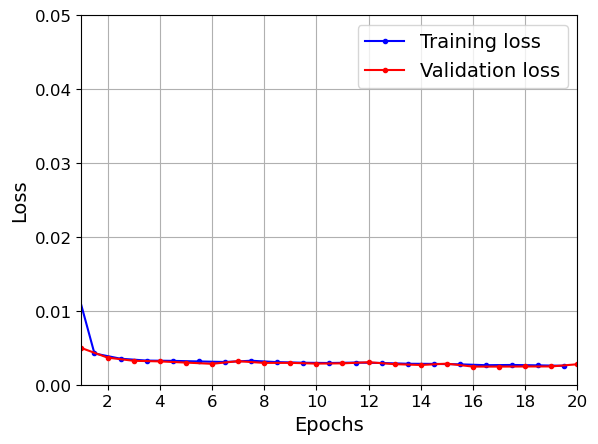

In [88]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

63/63 [==============================] - 0s 2ms/step


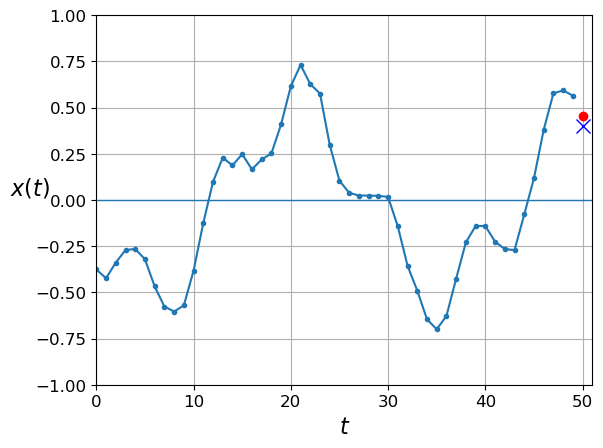

In [89]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [90]:
np.random.seed(43)

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

1/1 [==============================] - 0s 10ms/step


In [91]:
Y_pred.shape

(1, 10, 1)

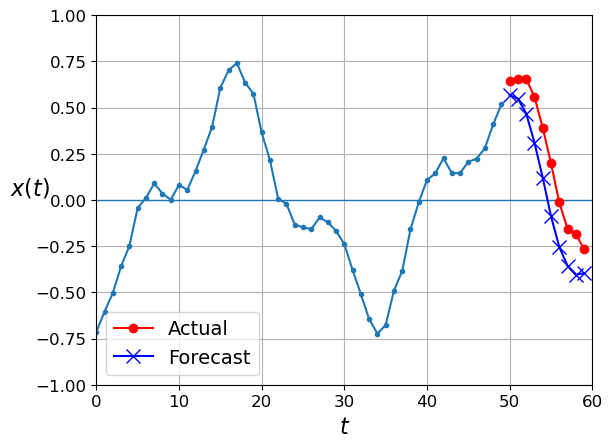

In [92]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], 'ro-', label='Actual')
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], 'bx-', label='Forecast', markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)

In [93]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [94]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

63/63 [==============================] - 0s 1ms/step


In [95]:
Y_pred.shape

(2000, 10)

In [96]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.022962203

In [97]:
Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.22278848

In [98]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 0s 697us/step - loss: 0.1317 - val_loss: 0.0638
Epoch 2/20
219/219 [==============================] - 0s 467us/step - loss: 0.0512 - val_loss: 0.0439
Epoch 3/20
219/219 [==============================] - 0s 464us/step - loss: 0.0391 - val_loss: 0.0360
Epoch 4/20
219/219 [==============================] - 0s 469us/step - loss: 0.0335 - val_loss: 0.0317
Epoch 5/20
219/219 [==============================] - 0s 462us/step - loss: 0.0301 - val_loss: 0.0289
Epoch 6/20
219/219 [==============================] - 0s 468us/step - loss: 0.0277 - val_loss: 0.0270
Epoch 7/20
219/219 [==============================] - 0s 468us/step - loss: 0.0260 - val_loss: 0.0254
Epoch 8/20
219/219 [==============================] - 0s 460us/step - loss: 0.0248 - val_loss: 0.0242
Epoch 9/20
219/219 [==============================] - 0s 455us/step - loss: 0.0238 - val_loss: 0.0234
Epoch 10/20
219/219 [==============================] - 0s 462us/step - loss: 0.023

In [99]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 2s 6ms/step - loss: 0.0627 - val_loss: 0.0314
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0258 - val_loss: 0.0198
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0186 - val_loss: 0.0163
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0161 - val_loss: 0.0152
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0144 - val_loss: 0.0122
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0136 - val_loss: 0.0117
Epoch 7/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0129 - val_loss: 0.0121
Epoch 8/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0121 - val_loss: 0.0113
Epoch 9/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0119 - val_loss: 0.0130
Epoch 10/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0118 - val_loss: 0.0108

In [100]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

1/1 [==============================] - 0s 110ms/step


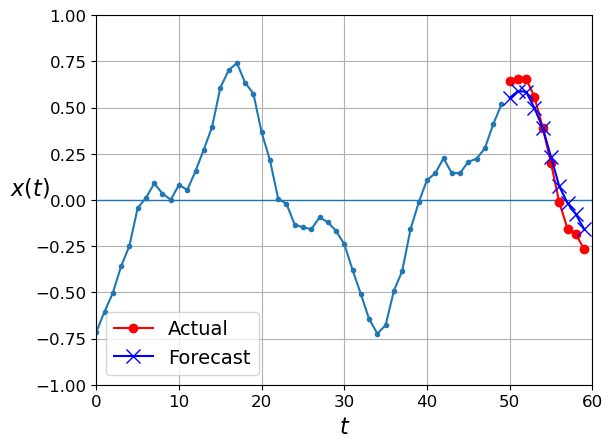

In [101]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)

In [102]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]

Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [103]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [104]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [105]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_18 (SimpleRNN)   (None, None, 20)          440       
                                                                 
 simple_rnn_19 (SimpleRNN)   (None, None, 20)          820       
                                                                 
 time_distributed_6 (TimeDi  (None, None, 10)          210       
 stributed)                                                      
                                                                 
Total params: 1470 (5.74 KB)
Trainable params: 1470 (5.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [106]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [107]:
model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0516 - last_time_step_mse: 0.0413 - val_loss: 0.0398 - val_last_time_step_mse: 0.0267
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0362 - last_time_step_mse: 0.0230 - val_loss: 0.0336 - val_last_time_step_mse: 0.0193
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0314 - last_time_step_mse: 0.0184 - val_loss: 0.0296 - val_last_time_step_mse: 0.0173
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0294 - last_time_step_mse: 0.0172 - val_loss: 0.0269 - val_last_time_step_mse: 0.0149
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0273 - last_time_step_mse: 0.0153 - val_loss: 0.0254 - val_last_time_step_mse: 0.0132
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0256 - last_time_step_mse: 0.0135 - val_loss: 0.0239 - val_last_time_step_mse: 0.0115
Epoch 7/20
219/219 [========

In [108]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][...,np.newaxis]

1/1 [==============================] - 0s 108ms/step


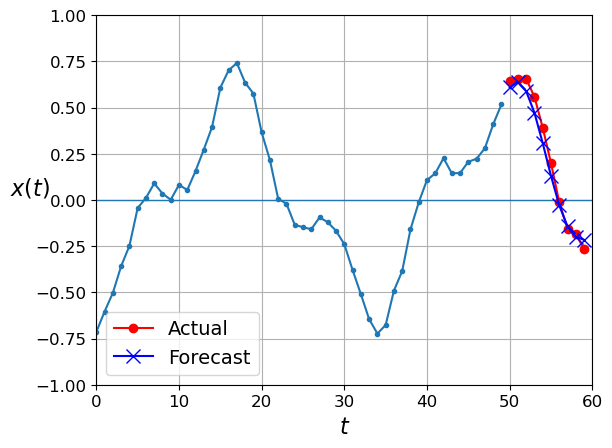

In [109]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)

In [110]:
from tensorflow.keras.layers import LayerNormalization

In [111]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation='tanh', **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [112]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 4s 14ms/step - loss: 0.1199 - last_time_step_mse: 0.1099 - val_loss: 0.0623 - val_last_time_step_mse: 0.0517
Epoch 2/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0569 - last_time_step_mse: 0.0464 - val_loss: 0.0523 - val_last_time_step_mse: 0.0410
Epoch 3/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0491 - last_time_step_mse: 0.0385 - val_loss: 0.0462 - val_last_time_step_mse: 0.0355
Epoch 4/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0447 - last_time_step_mse: 0.0343 - val_loss: 0.0427 - val_last_time_step_mse: 0.0320
Epoch 5/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0419 - last_time_step_mse: 0.0312 - val_loss: 0.0409 - val_last_time_step_mse: 0.0294
Epoch 6/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0394 - last_time_step_mse: 0.0285 - val_loss: 0.0381 - val_last_time_step_mse: 0.0266
Epoch 7/20
219/219 [==

In [113]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(
            self.cell, 'get_initial_state', self.fallback_initial_state
        )
        
    def fallback_initial_state(self, inputs):
        return [tf.zeros([self.cell.state_size], dtype=inputs.dtype)]
    
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        n_steps = tf.shape(inputs)[1]
        if self.return_sequences:
            sequences = tf.TensorArray(inputs.dtype, size=n_steps)
        outputs = tf.zeros(shape=[n_steps, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return sequences.stack()
        else:
            return outputs
            

In [114]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True,
          input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 4s 13ms/step - loss: 0.1623 - last_time_step_mse: 0.1507 - val_loss: 0.0720 - val_last_time_step_mse: 0.0644
Epoch 2/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0636 - last_time_step_mse: 0.0536 - val_loss: 0.0577 - val_last_time_step_mse: 0.0466
Epoch 3/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0540 - last_time_step_mse: 0.0423 - val_loss: 0.0509 - val_last_time_step_mse: 0.0390
Epoch 4/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0480 - last_time_step_mse: 0.0364 - val_loss: 0.0458 - val_last_time_step_mse: 0.0344
Epoch 5/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0438 - last_time_step_mse: 0.0329 - val_loss: 0.0423 - val_last_time_step_mse: 0.0312
Epoch 6/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0406 - last_time_step_mse: 0.0296 - val_loss: 0.0384 - val_last_time_step_mse: 0.0264
Epoch 7/20
219/219 [==

In [115]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 16ms/step - loss: 0.0772 - last_time_step_mse: 0.0623 - val_loss: 0.0549 - val_last_time_step_mse: 0.0355
Epoch 2/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0474 - last_time_step_mse: 0.0269 - val_loss: 0.0415 - val_last_time_step_mse: 0.0196
Epoch 3/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0379 - last_time_step_mse: 0.0169 - val_loss: 0.0356 - val_last_time_step_mse: 0.0150
Epoch 4/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0339 - last_time_step_mse: 0.0143 - val_loss: 0.0328 - val_last_time_step_mse: 0.0133
Epoch 5/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0319 - last_time_step_mse: 0.0133 - val_loss: 0.0313 - val_last_time_step_mse: 0.0130
Epoch 6/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0304 - last_time_step_mse: 0.0125 - val_loss: 0.0295 - val_last_time_step_mse: 0.0117
Epoch 7/20
219/219 [==

In [116]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0232 - last_time_step_mse: 0.0077


[0.02320411615073681, 0.007655980531126261]

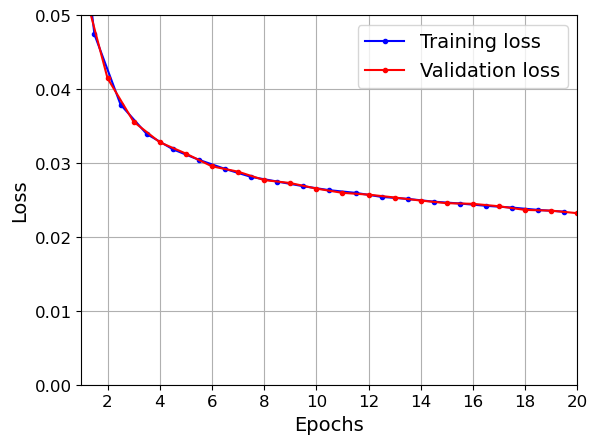

In [117]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [118]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 0s 313ms/step


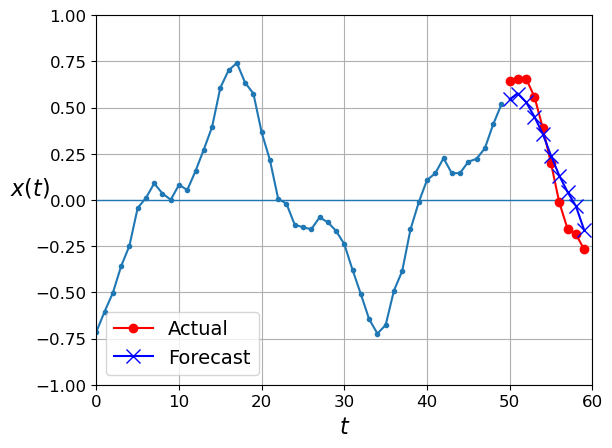

In [119]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)

In [120]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 15ms/step - loss: 0.0704 - last_time_step_mse: 0.0616 - val_loss: 0.0517 - val_last_time_step_mse: 0.0406
Epoch 2/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0477 - last_time_step_mse: 0.0371 - val_loss: 0.0449 - val_last_time_step_mse: 0.0338
Epoch 3/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0431 - last_time_step_mse: 0.0318 - val_loss: 0.0407 - val_last_time_step_mse: 0.0290
Epoch 4/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0386 - last_time_step_mse: 0.0263 - val_loss: 0.0356 - val_last_time_step_mse: 0.0229
Epoch 5/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0335 - last_time_step_mse: 0.0199 - val_loss: 0.0313 - val_last_time_step_mse: 0.0171
Epoch 6/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0302 - last_time_step_mse: 0.0151 - val_loss: 0.0291 - val_last_time_step_mse: 0.0141
Epoch 7/20
219/219 [==

In [121]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0230 - last_time_step_mse: 0.0090


[0.022990865632891655, 0.009032943286001682]

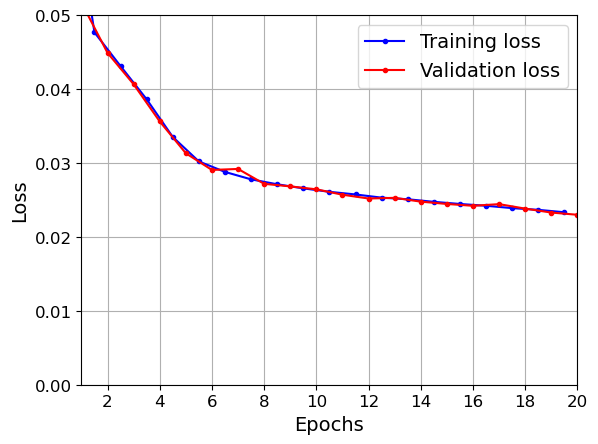

In [122]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [123]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 0s 291ms/step


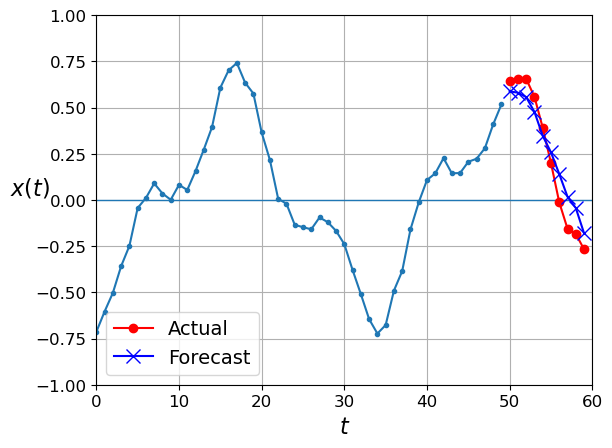

In [124]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [125]:
X_train.shape

(7000, 50, 1)

In [126]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding='valid',
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 4s 9ms/step - loss: 0.0689 - last_time_step_mse: 0.0605 - val_loss: 0.0443 - val_last_time_step_mse: 0.0350
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0383 - last_time_step_mse: 0.0303 - val_loss: 0.0331 - val_last_time_step_mse: 0.0238
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0308 - last_time_step_mse: 0.0217 - val_loss: 0.0289 - val_last_time_step_mse: 0.0195
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0275 - last_time_step_mse: 0.0178 - val_loss: 0.0261 - val_last_time_step_mse: 0.0162
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0253 - last_time_step_mse: 0.0152 - val_loss: 0.0251 - val_last_time_step_mse: 0.0158
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0237 - last_time_step_mse: 0.0132 - val_loss: 0.0231 - val_last_time_step_mse: 0.0123
Epoch 7/20
219/219 [========

In [128]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1,2,4,8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding='causal',
                                  activation='relu', dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0673 - last_time_step_mse: 0.0550 - val_loss: 0.0366 - val_last_time_step_mse: 0.0224
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0328 - last_time_step_mse: 0.0197 - val_loss: 0.0299 - val_last_time_step_mse: 0.0168
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0288 - last_time_step_mse: 0.0162 - val_loss: 0.0279 - val_last_time_step_mse: 0.0156
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0267 - last_time_step_mse: 0.0142 - val_loss: 0.0258 - val_last_time_step_mse: 0.0134
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0253 - last_time_step_mse: 0.0131 - val_loss: 0.0247 - val_last_time_step_mse: 0.0127
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0241 - last_time_step_mse: 0.0121 - val_loss: 0.0237 - val_last_time_step_mse: 0.0116
Epoch 7/20
219/219 [========

## 연습문제
### 9

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [2]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir='datasets/quickdraw',
                                extract=True)

In [3]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob('training.tfrecord-*')])
eval_files = sorted([str(path) for path in quickdraw_dir.glob('eval.tfrecord-*')])

In [4]:
train_files

['/Users/taemin/.keras/datasets/quickdraw/training.tfrecord-00000-of-00010',
 '/Users/taemin/.keras/datasets/quickdraw/training.tfrecord-00001-of-00010',
 '/Users/taemin/.keras/datasets/quickdraw/training.tfrecord-00002-of-00010',
 '/Users/taemin/.keras/datasets/quickdraw/training.tfrecord-00003-of-00010',
 '/Users/taemin/.keras/datasets/quickdraw/training.tfrecord-00004-of-00010',
 '/Users/taemin/.keras/datasets/quickdraw/training.tfrecord-00005-of-00010',
 '/Users/taemin/.keras/datasets/quickdraw/training.tfrecord-00006-of-00010',
 '/Users/taemin/.keras/datasets/quickdraw/training.tfrecord-00007-of-00010',
 '/Users/taemin/.keras/datasets/quickdraw/training.tfrecord-00008-of-00010',
 '/Users/taemin/.keras/datasets/quickdraw/training.tfrecord-00009-of-00010']

In [5]:
eval_files

['/Users/taemin/.keras/datasets/quickdraw/eval.tfrecord-00000-of-00010',
 '/Users/taemin/.keras/datasets/quickdraw/eval.tfrecord-00001-of-00010',
 '/Users/taemin/.keras/datasets/quickdraw/eval.tfrecord-00002-of-00010',
 '/Users/taemin/.keras/datasets/quickdraw/eval.tfrecord-00003-of-00010',
 '/Users/taemin/.keras/datasets/quickdraw/eval.tfrecord-00004-of-00010',
 '/Users/taemin/.keras/datasets/quickdraw/eval.tfrecord-00005-of-00010',
 '/Users/taemin/.keras/datasets/quickdraw/eval.tfrecord-00006-of-00010',
 '/Users/taemin/.keras/datasets/quickdraw/eval.tfrecord-00007-of-00010',
 '/Users/taemin/.keras/datasets/quickdraw/eval.tfrecord-00008-of-00010',
 '/Users/taemin/.keras/datasets/quickdraw/eval.tfrecord-00009-of-00010']

In [6]:
with open(quickdraw_dir / 'eval.tfrecord.classes') as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / 'training.tfrecord.classes') as train_classes_file:
    train_classes = train_classes_file.readlines()

In [7]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [8]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [9]:
def parse(data_batch):
    feature_descriptions = {
        'ink': tf.io.VarLenFeature(dtype=tf.float32),
        'shape': tf.io.FixedLenFeature([2], dtype=tf.int64),
        'class_index': tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples['ink'])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples['shape'][:, 0]
    labels = examples['class_index'][:, 0]
    return sketches, lengths, labels

In [10]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [11]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [12]:
for sketches, lengths, labels in train_set.take(1):
    print('sketches = ', sketches)
    print('lengths = ', lengths)
    print('labels = ', labels)

sketches =  tf.Tensor(
[[[-0.0944882  -0.04663213  0.        ]
  [-0.08661417  0.04145078  0.        ]
  [-0.03937007  0.05181348  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.04313726 -0.14960629  0.        ]
  [ 0.06274509 -0.40551183  0.        ]
  [ 0.04313726 -0.12598425  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.          0.          1.        ]
  [ 0.          0.          0.        ]
  [-0.19607842 -0.03174603  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[-0.12790698  0.01960784  0.        ]
  [-0.02906978  0.2117647   0.        ]
  [-0.04651159  0.06274509  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.   

In [13]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else 'Try to guess'
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], 'y:')
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], '.-')
    plt.axis('off')

In [14]:
def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)

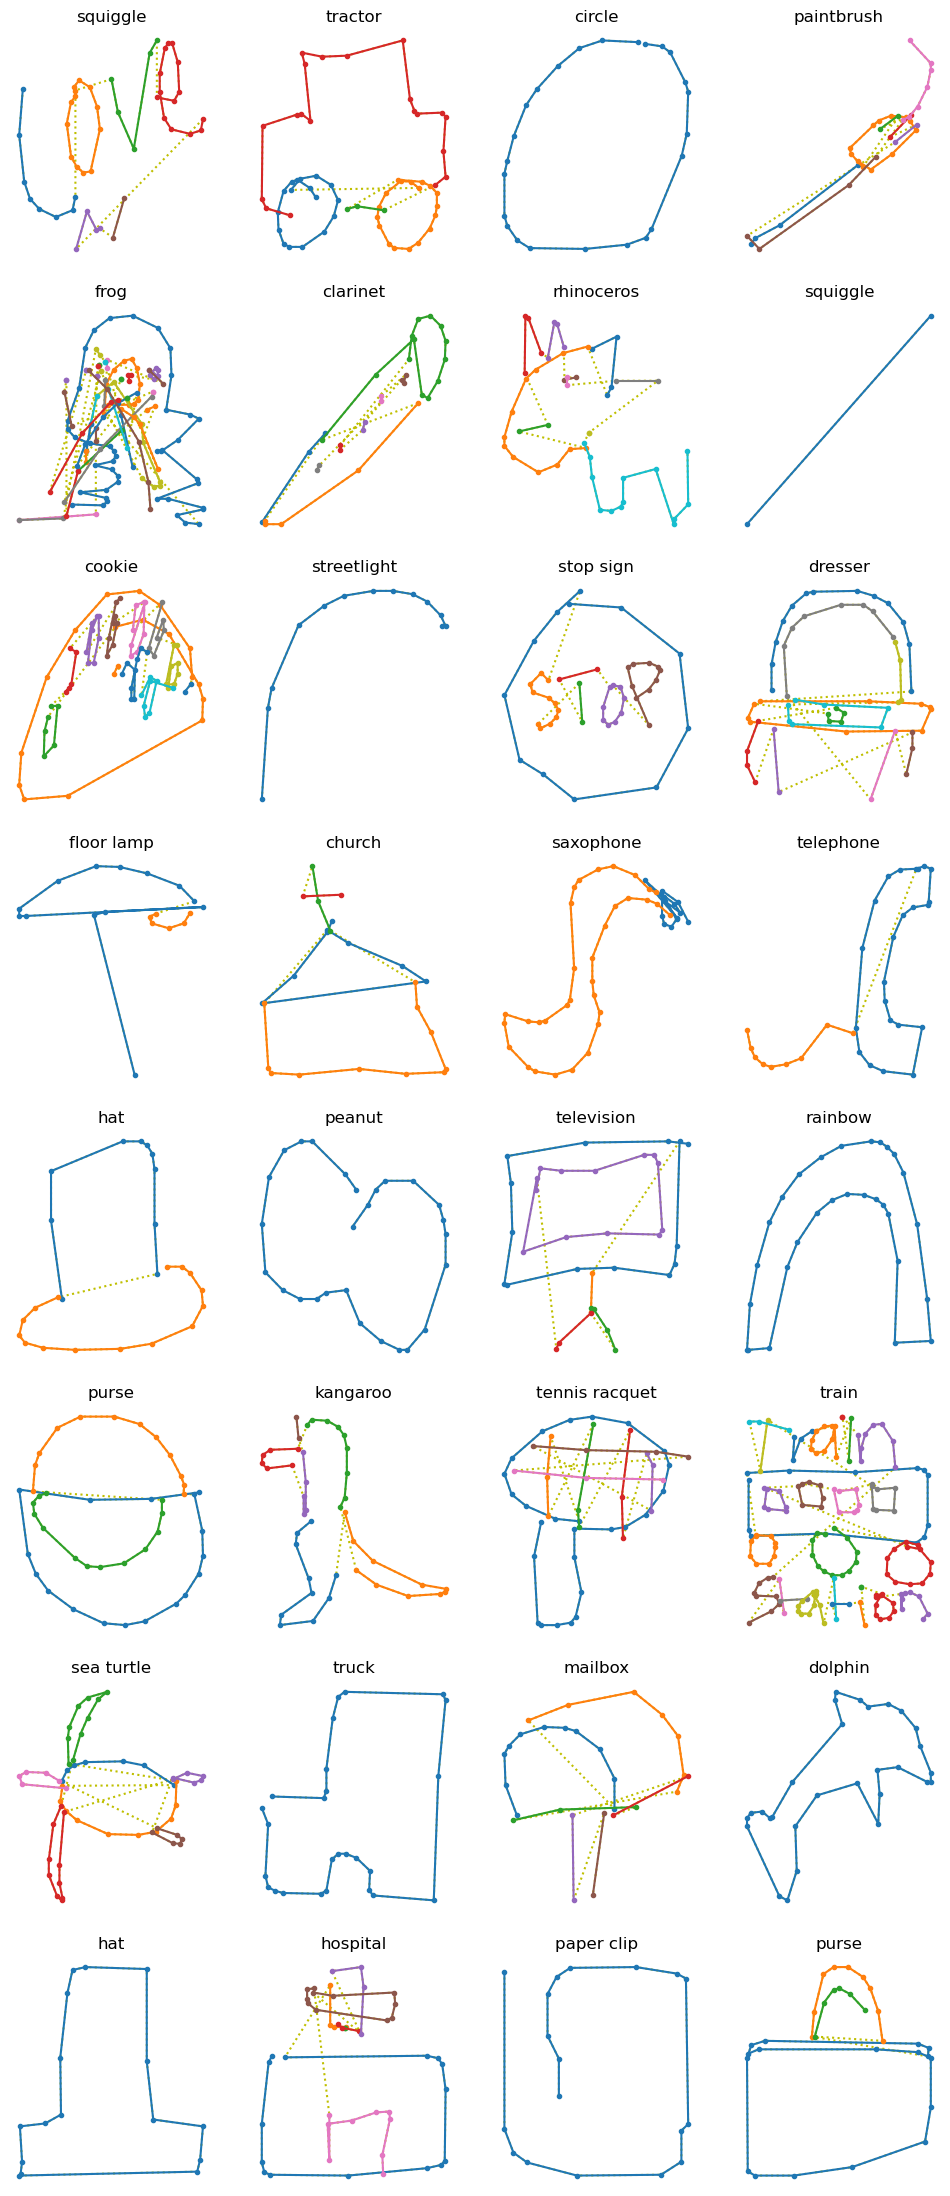

In [15]:
for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

(0.0, 200.0, 0.0, 0.03)

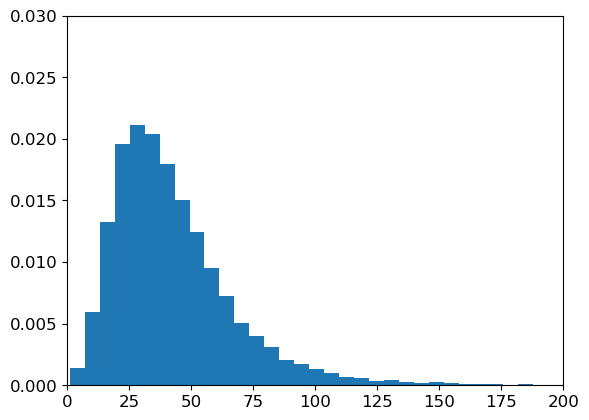

In [16]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])


In [17]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

In [18]:
cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [25]:
model = keras.models.load_model('sketchrnn_model')

if model is None:
    model = keras.models.Sequential([
        keras.layers.Conv1D(32, kernel_size=5, strides=2, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(64, kernel_size=5, strides=2, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(128, kernel_size=3, strides=2, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.LSTM(128, return_sequences=True),
        keras.layers.LSTM(128),
        keras.layers.Dense(len(class_names), activation='softmax')
    ])
    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-2, clipnorm=1.)
    model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy', 'sparse_top_k_categorical_accuracy'])
    history = model.fit(cropped_train_set, epochs=2,
                        validation_data=cropped_valid_set)
    model.save('sketchrnn_model', overwrite=False)    

In [21]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

5392/5392 [==============================] - 59s 11ms/step


In [22]:
np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

0.5957758

1/1 [==============================] - 0s 362ms/step


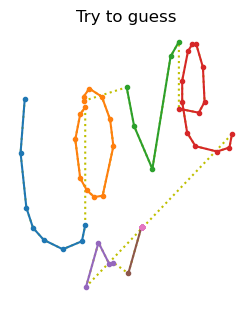

Top-5 predictions:
  1. animal migration 22.267%
  2. rain 13.753%
  3. smiley face 13.375%
  4. sun 12.442%
  5. stethoscope 7.904%
Answer: squiggle


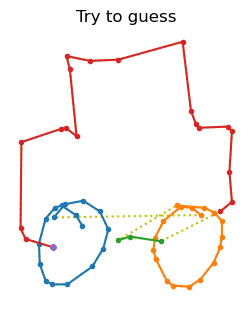

Top-5 predictions:
  1. tractor 38.146%
  2. headphones 15.457%
  3. motorbike 11.338%
  4. eyeglasses 4.544%
  5. car 4.296%
Answer: tractor


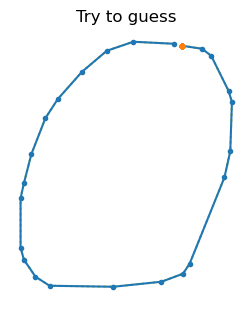

Top-5 predictions:
  1. circle 19.451%
  2. hexagon 14.954%
  3. octagon 13.383%
  4. moon 5.127%
  5. ear 4.034%
Answer: circle


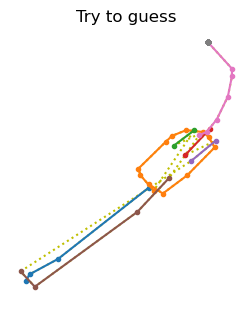

Top-5 predictions:
  1. yoga 13.098%
  2. syringe 12.831%
  3. animal migration 9.304%
  4. screwdriver 7.038%
  5. shovel 6.408%
Answer: paintbrush


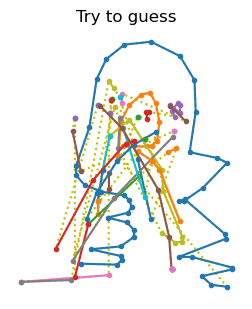

Top-5 predictions:
  1. octopus 18.233%
  2. the mona lisa 9.134%
  3. lion 6.229%
  4. squirrel 6.185%
  5. brain 5.470%
Answer: frog


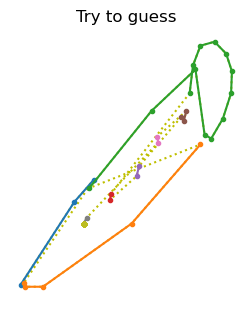

Top-5 predictions:
  1. stitches 15.074%
  2. feather 10.444%
  3. smiley face 7.877%
  4. animal migration 4.930%
  5. wristwatch 4.820%
Answer: clarinet


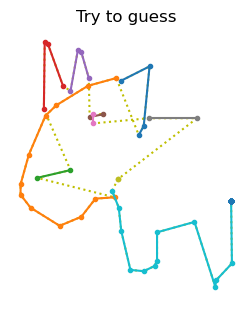

Top-5 predictions:
  1. sun 20.945%
  2. key 16.536%
  3. animal migration 8.457%
  4. bottlecap 3.094%
  5. rhinoceros 2.855%
Answer: rhinoceros


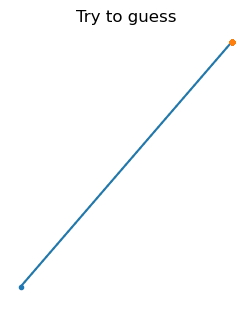

Top-5 predictions:
  1. line 70.599%
  2. leg 5.048%
  3. pear 2.089%
  4. broom 2.019%
  5. nose 1.511%
Answer: squiggle


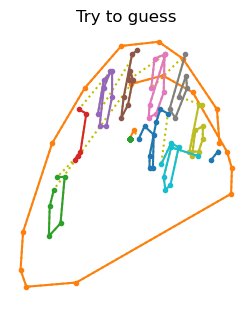

Top-5 predictions:
  1. stop sign 29.359%
  2. cow 16.837%
  3. garden 12.040%
  4. rhinoceros 2.365%
  5. brain 1.954%
Answer: cookie


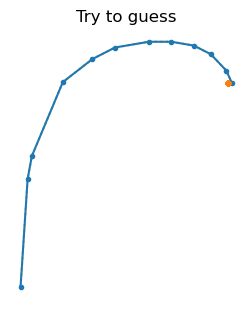

Top-5 predictions:
  1. streetlight 17.080%
  2. finger 7.279%
  3. garden hose 5.846%
  4. pear 4.806%
  5. diving board 4.270%
Answer: streetlight


In [23]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print('Top-5 predictions:'.format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print('  {}. {} {:.3f}%'.format(k + 1, class_name, proba))
    print('Answer: {}'.format(class_names[labels[index].numpy()]))